In [2]:
!pwd

/home/bms/Documents/phd-study/2025-fall/cs-204-networks/project/cs204-quic/aioquic/analytics


In [3]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from analyze import QLogAnalyzer  # your module


In [4]:

LOG_DIR = "../pkt_logs/2025-11-13_20-01-17"

# Describe each experiment for titles/legends
EXPERIMENTS = [
    {"id": 0,  "label": "EX0: Baseline (no tc)",                     "rtt": "local", "loss": "0%",   "rate": "∞"},

    {"id": 1,  "label": "EX1: RTT=10ms, 0% loss, 20Mbit",            "rtt": "10ms", "loss": "0%",   "rate": "20M"},
    {"id": 2,  "label": "EX2: RTT=10ms, 0.5% loss, 20Mbit",          "rtt": "10ms", "loss": "0.5%", "rate": "20M"},
    {"id": 3,  "label": "EX3: RTT=10ms, 2% loss, 20Mbit",            "rtt": "10ms", "loss": "2%",   "rate": "20M"},

    {"id": 4,  "label": "EX4: RTT=10ms, 0% loss, 10Mbit",            "rtt": "10ms", "loss": "0%",   "rate": "10M"},
    {"id": 5,  "label": "EX5: RTT=10ms, 0.5% loss, 10Mbit",          "rtt": "10ms", "loss": "0.5%", "rate": "10M"},
    {"id": 6,  "label": "EX6: RTT=10ms, 2% loss, 10Mbit",            "rtt": "10ms", "loss": "2%",   "rate": "10M"},

    {"id": 7,  "label": "EX7: RTT=50ms, 0% loss, 20Mbit",            "rtt": "50ms", "loss": "0%",   "rate": "20M"},
    {"id": 8,  "label": "EX8: RTT=50ms, 0.5% loss, 20Mbit",          "rtt": "50ms", "loss": "0.5%", "rate": "20M"},
    {"id": 9,  "label": "EX9: RTT=50ms, 2% loss, 20Mbit",            "rtt": "50ms", "loss": "2%",   "rate": "20M"},

    {"id": 10, "label": "EX10: RTT=50ms, 0% loss, 10Mbit",           "rtt": "50ms", "loss": "0%",   "rate": "10M"},
    {"id": 11, "label": "EX11: RTT=50ms, 0.5% loss, 10Mbit",         "rtt": "50ms", "loss": "0.5%", "rate": "10M"},
    {"id": 12, "label": "EX12: RTT=50ms, 2% loss, 10Mbit",           "rtt": "50ms", "loss": "2%",   "rate": "10M"},

    {"id": 13, "label": "EX13: RTT=100ms, 0% loss, 20Mbit",          "rtt": "100ms", "loss": "0%",   "rate": "20M"},
    {"id": 14, "label": "EX14: RTT=100ms, 0.5% loss, 20Mbit",        "rtt": "100ms", "loss": "0.5%", "rate": "20M"},
    {"id": 15, "label": "EX15: RTT=100ms, 2% loss, 20Mbit",          "rtt": "100ms", "loss": "2%",   "rate": "20M"},

    {"id": 16, "label": "EX16: RTT=100ms, 0% loss, 10Mbit",          "rtt": "100ms", "loss": "0%",   "rate": "10M"},
    {"id": 17, "label": "EX17: RTT=100ms, 0.5% loss, 10Mbit",        "rtt": "100ms", "loss": "0.5%", "rate": "10M"},
    {"id": 18, "label": "EX18: RTT=100ms, 2% loss, 10Mbit",          "rtt": "100ms", "loss": "2%",   "rate": "10M"},
]



In [8]:
def find_qlog_for_experiment(exp_id: int) -> str:
    pattern = os.path.join(LOG_DIR, f"EX_{exp_id}_client_*_log.json")
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No qlog found for experiment {exp_id}")
    # if multiple, take the most recent
    return sorted(files)[-1]

def load_metrics(qlog_path: str):
    qla = QLogAnalyzer(qlog_path)

    cwnd_df = pd.DataFrame(qla.analyze_cwnd())
    rtt_df  = pd.DataFrame(qla.analyze_rtt())
    loss_df = pd.DataFrame(qla.analyze_loss())
    gdpt_output = qla.analyze_goodput()
    print(gdpt_output)
    gdpt_df = pd.DataFrame([gdpt_output])

    # time normalization
    for df in [cwnd_df, rtt_df, loss_df]:
        if not df.empty:
            t0 = df["time"].iloc[0]
            df["time_rel"] = df["time"] - t0

    return cwnd_df, rtt_df, loss_df, gdpt_df


In [9]:

def plot_experiment_on_axes(ax, exp, show_legend=False, show_ylabel=False, show_xlabel=False):
    """
    Draw cwnd + RTT (and optional loss markers) for one experiment on given axes.
    """
    exp_id = exp["id"]
    label  = exp["label"]

    qlog_path = find_qlog_for_experiment(exp_id)
    cwnd_df, rtt_df, loss_df, _ = load_metrics(qlog_path)

    # CWND on main axis
    if not cwnd_df.empty:
        ax.plot(cwnd_df["time_rel"], cwnd_df["cwnd"], label="cwnd (bytes)")
    if show_ylabel:
        ax.set_ylabel("cwnd (bytes)")
    ax.grid(True, alpha=0.3)

    # RTT on twin axis
    if not rtt_df.empty:
        ax2 = ax.twinx()
        ax2.plot(rtt_df["time_rel"], rtt_df["smoothed_rtt"],
                 color="tab:red", alpha=0.7, label="smoothed_rtt (ms)")
        if show_ylabel:
            ax2.set_ylabel("RTT (ms)")
    else:
        ax2 = None

    if show_xlabel:
        ax.set_xlabel("Time (relative)")

    # Shorter title so it fits in small subplots
    ax.set_title(label, fontsize=10)

    # Optional legend (e.g., only for EX0)
    if show_legend:
        handles, labels = [], []
        h, l = ax.get_legend_handles_labels()
        handles.extend(h); labels.extend(l)
        if ax2 is not None:
            h2, l2 = ax2.get_legend_handles_labels()
            handles.extend(h2); labels.extend(l2)
        if handles:
            ax.legend(handles, labels, loc="upper left", fontsize=9)


{'bytes': 6616164, 'duration': 60.143501708984374, 'goodput_mbps': 0.8800503877560774}
{'bytes': 6588656, 'duration': 60.29895336914063, 'goodput_mbps': 0.8741320546199591}
{'bytes': 6607792, 'duration': 60.35293701171875, 'goodput_mbps': 0.8758867193113684}
{'bytes': 6617360, 'duration': 60.36636254882813, 'goodput_mbps': 0.8769599121891715}
{'bytes': 6622144, 'duration': 60.3206787109375, 'goodput_mbps': 0.8782585529892927}
{'bytes': 6593440, 'duration': 60.35369458007813, 'goodput_mbps': 0.8739733394450915}
{'bytes': 6565932, 'duration': 60.33209643554687, 'goodput_mbps': 0.8706386667023146}
{'bytes': 6595832, 'duration': 60.392271728515624, 'goodput_mbps': 0.8737319277738809}
{'bytes': 6586264, 'duration': 60.35484228515625, 'goodput_mbps': 0.873005545289258}
{'bytes': 6498956, 'duration': 60.432501708984375, 'goodput_mbps': 0.8603259261112222}
{'bytes': 6593440, 'duration': 60.422967529296876, 'goodput_mbps': 0.8729713576948147}
{'bytes': 6577892, 'duration': 60.43527490234375, 'g

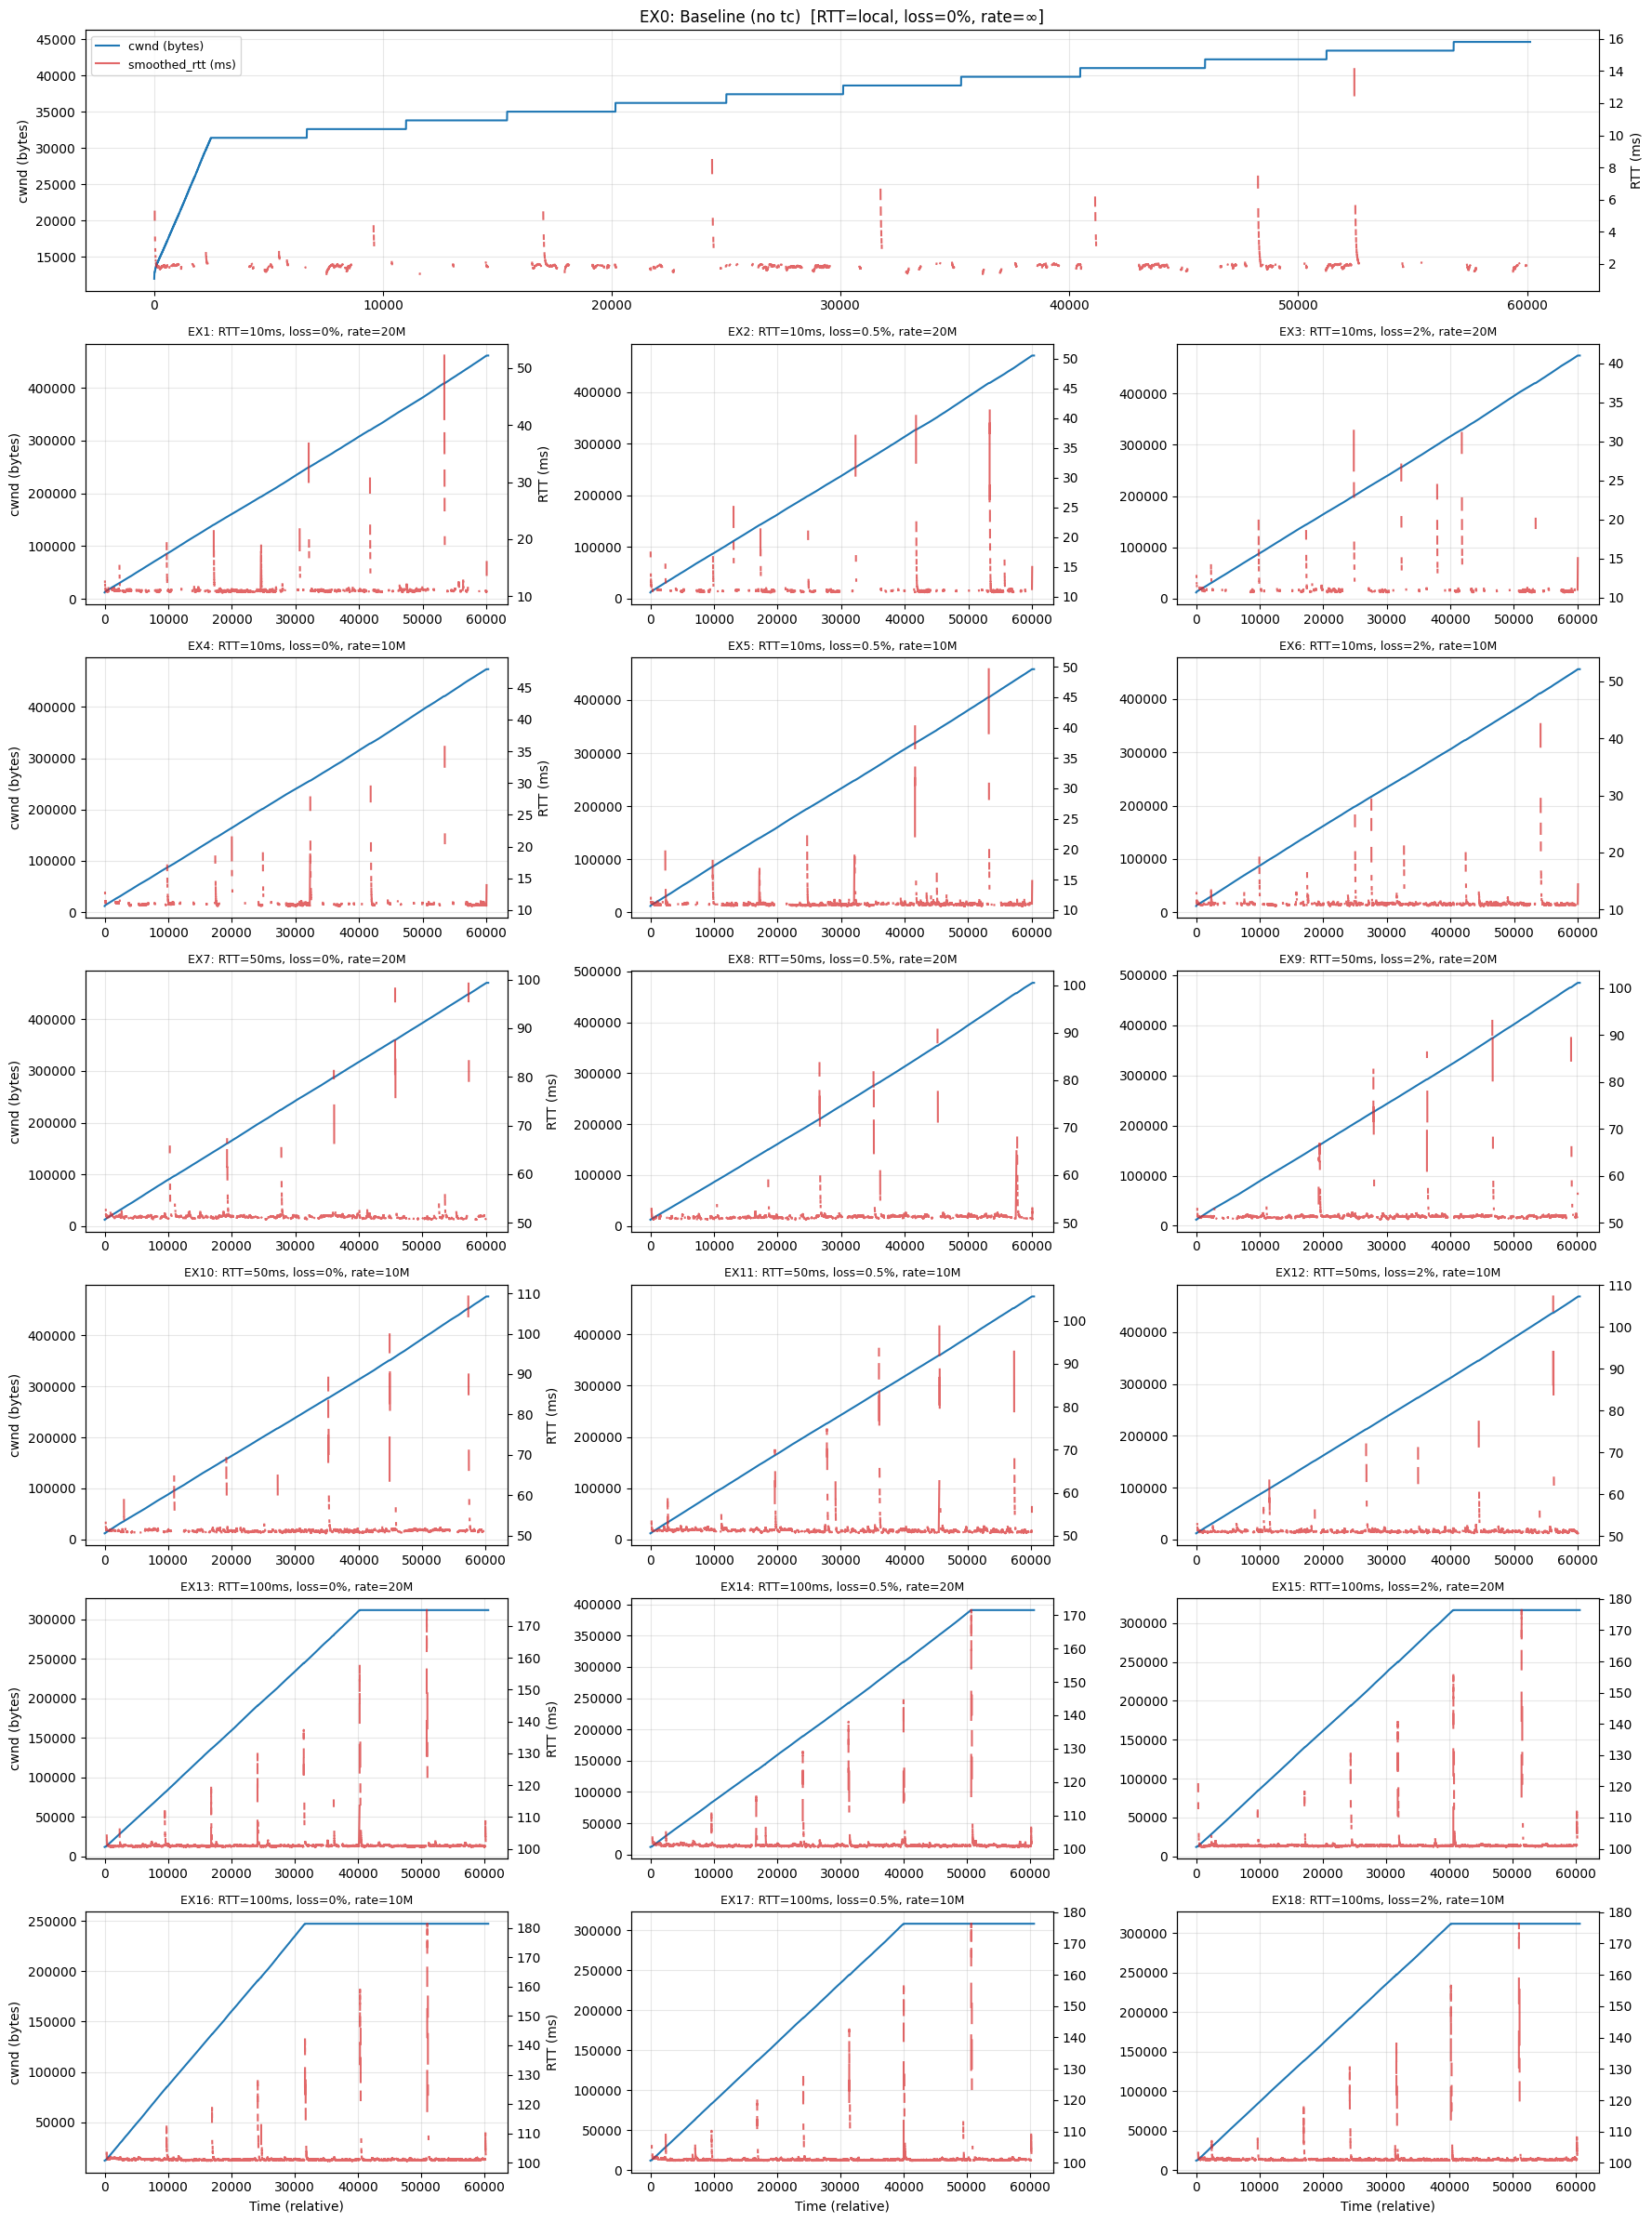

In [10]:

fig = plt.figure(figsize=(18, 24))
gs = GridSpec(7, 3, figure=fig)

# ----- Row 1: EX0 spanning all 3 columns -----
ax_big = fig.add_subplot(gs[0, :])
plot_experiment_on_axes(
    ax_big,
    EXPERIMENTS[0],      # EX0
    show_legend=True,
    show_ylabel=True,
    show_xlabel=False,
)
ax_big.set_title(EXPERIMENTS[0]["label"] + 
                 f"  [RTT={EXPERIMENTS[0]['rtt']}, loss={EXPERIMENTS[0]['loss']}, rate={EXPERIMENTS[0]['rate']}]", 
                 fontsize=12)

# ----- Rows 2–7: groups of 3 experiments per row -----
# Mapping: each inner list is the experiment indices (in EXPERIMENTS) for that row
rows_indices = [
    [1, 2, 3],      # row 2
    [4, 5, 6],      # row 3
    [7, 8, 9],      # row 4
    [10, 11, 12],   # row 5
    [13, 14, 15],   # row 6
    [16, 17, 18],   # row 7
]

for row_offset, exp_idxs in enumerate(rows_indices, start=1):  # start at grid row 1
    for col, exp_idx in enumerate(exp_idxs):
        ax = fig.add_subplot(gs[row_offset, col])

        # Only left-most plot in each row shows y-labels
        show_ylabel = (col == 0)
        # Only bottom row shows x-labels
        show_xlabel = (row_offset == len(rows_indices))

        plot_experiment_on_axes(
            ax,
            EXPERIMENTS[exp_idx],
            show_legend=False,
            show_ylabel=show_ylabel,
            show_xlabel=show_xlabel,
        )

        exp = EXPERIMENTS[exp_idx]
        ax.set_title(
            f"EX{exp['id']}: RTT={exp['rtt']}, loss={exp['loss']}, rate={exp['rate']}",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

In [13]:
summary_rows = []

for exp in EXPERIMENTS:
    exp_id = exp["id"]
    qlog_path = find_qlog_for_experiment(exp_id)
    cwnd_df, rtt_df, loss_df, gdpt_df = load_metrics(qlog_path)

    row = {
        "id": exp_id,
        "label": exp["label"],
        "RTT_cfg": exp["rtt"],
        "loss_cfg": exp["loss"],
        "rate_cfg": exp["rate"],
        "avg_cwnd": cwnd_df["cwnd"].mean() if not cwnd_df.empty else None,
        "max_cwnd": cwnd_df["cwnd"].max() if not cwnd_df.empty else None,
        "avg_rtt": rtt_df["smoothed_rtt"].mean() if not rtt_df.empty else None,
        "loss_events": len(loss_df),
        "goodput_mbps": gdpt_df["goodput_mbps"].iloc[0],
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df


{'bytes': 6616164, 'duration': 60.143501708984374, 'goodput_mbps': 0.8800503877560774}
{'bytes': 6588656, 'duration': 60.29895336914063, 'goodput_mbps': 0.8741320546199591}
{'bytes': 6607792, 'duration': 60.35293701171875, 'goodput_mbps': 0.8758867193113684}
{'bytes': 6617360, 'duration': 60.36636254882813, 'goodput_mbps': 0.8769599121891715}
{'bytes': 6622144, 'duration': 60.3206787109375, 'goodput_mbps': 0.8782585529892927}
{'bytes': 6593440, 'duration': 60.35369458007813, 'goodput_mbps': 0.8739733394450915}
{'bytes': 6565932, 'duration': 60.33209643554687, 'goodput_mbps': 0.8706386667023146}
{'bytes': 6595832, 'duration': 60.392271728515624, 'goodput_mbps': 0.8737319277738809}
{'bytes': 6586264, 'duration': 60.35484228515625, 'goodput_mbps': 0.873005545289258}
{'bytes': 6498956, 'duration': 60.432501708984375, 'goodput_mbps': 0.8603259261112222}
{'bytes': 6593440, 'duration': 60.422967529296876, 'goodput_mbps': 0.8729713576948147}
{'bytes': 6577892, 'duration': 60.43527490234375, 'g

,id,label,RTT_cfg,loss_cfg,rate_cfg,avg_cwnd,max_cwnd,avg_rtt,loss_events,goodput_mbps
0,0,EX0: Baseline (no tc),local,0%,∞,37426.808162,44607,1.839615,0,0.880050
1,1,"EX1: RTT=10ms, 0% loss, 20Mbit",10ms,0%,20M,233208.971067,461456,11.157736,0,0.874132
2,2,"EX2: RTT=10ms, 0.5% loss, 20Mbit",10ms,0.5%,20M,238747.890021,470950,11.198267,0,0.875887
3,3,"EX3: RTT=10ms, 2% loss, 20Mbit",10ms,2%,20M,240320.527672,473799,11.168883,0,0.876960
4,4,"EX4: RTT=10ms, 0% loss, 10Mbit",10ms,0%,10M,241406.058456,473511,11.188259,0,0.878259
5,5,"EX5: RTT=10ms, 0.5% loss, 10Mbit",10ms,0.5%,10M,231988.447645,458182,11.114250,0,0.873973
6,6,"EX6: RTT=10ms, 2% loss, 10Mbit",10ms,2%,10M,230274.878459,455262,11.175278,0,0.870639
7,7,"EX7: RTT=50ms, 0% loss, 20Mbit",50ms,0%,20M,240999.053958,470777,51.444547,0,0.873732
8,8,"EX8: RTT=50ms, 0.5% loss, 20Mbit",50ms,0.5%,20M,238858.692777,477550,51.456712,0,0.873006
9,9,"EX9: RTT=50ms, 2% loss, 20Mbit",50ms,2%,20M,245446.694889,484753,51.609171,0,0.860326
